In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, accuracy_score, f1_score, precision_score, recall_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, OneHotEncoder
import wandb

In [2]:
wandb.login(key='288db8f5afccc57f269ae50ac116d15047b1b705')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: mitanshkayathwal (mmavericks). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/mitanshk/.netrc


True

In [3]:
df = pd.read_csv("WineQT.csv")
df.drop('Id',axis=1,inplace=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
X = df.drop(columns=['quality'])
y = df['quality']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [5]:
X_train.fillna(X_train.mean(), inplace=True)
X_val.fillna(X_val.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

std_scaler = StandardScaler()  
X_train_final = std_scaler.fit_transform(X_train)
X_val_final = std_scaler.transform(X_val)
X_test_final = std_scaler.transform(X_test)

In [16]:
# Write a basic MLP Class using activations, optimizers, hidden layers ...

class MLPClassifier:
    def __init__(self, X, y, learning_rate, activation_fn, num_layers, hidden_layer_sizes, epochs, optimizer='sgd', output_size = 6):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.activation = activation_fn
        self.num_layers = num_layers
        self.hidden_layer_sizes = hidden_layer_sizes
        self.epochs = epochs
        self.output_size = output_size
        if(optimizer == 'sgd'):
            self.optimizer = self.stochastic_gradient_descent
        elif(optimizer == 'batch'):
            self.optimizer = self.batch_gradient_descent
        else:
            self.optimizer = self.minibatch_gradient_descent
    
    def one_hot_encode(self, y):
        max_label_num = 6
        one_hot_matrix = np.zeros((len(y), max_label_num))
        one_hot_matrix[np.arange(len(y)), np.array(y) - 3] = 1
        
        return one_hot_matrix
    
    def cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  
        return -np.mean(y_true * np.log(y_pred + epsilon))
    
    def get_loss(self, X, y):
        y = self.one_hot_encode(y)
        self.forward_propagation(X)
        self.cross_entropy_loss(y, self.output)

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)

    def initialize_params(self):
        layers = [self.X.shape[1]] + self.hidden_layer_sizes + [self.output_size]

        self.weights = [np.random.randn(layers[i], layers[i+1]) for i in range(0,len(layers)-1)]
        self.biases = [np.zeros((1, layers[i])) for i in range(1,len(layers))]
        
    def derivative_activation(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - x**2
    
    def forward_propagation(self, X):
        self.activations = []
        activation_output = -1
        layer_input = X
        self.activations.append(layer_input)
        for i in range(len(self.hidden_layer_sizes)+1):
            layer_output = np.dot(layer_input, self.weights[i]) + self.biases[i]
            if self.activation == 'relu':
                activation_output = self.relu(layer_output)
            elif self.activation == 'sigmoid':
                activation_output = self.sigmoid(layer_output)
            elif self.activation == 'tanh':
                activation_output = self.tanh(layer_output)
            self.activations.append(activation_output)
            layer_input = activation_output

        self.output = self.softmax(self.activations[-1])
        return self.output

    def accuracy(self, y_pred, y):
        return accuracy_score(y_pred,y)

    def backward_propagation(self, y):
        gradient_weights = [np.zeros(w.shape) for w in self.weights]
        gradient_biases = [np.zeros(b.shape) for b in self.biases]
        error = (self.output - y) *  self.derivative_activation(self.activations[-1])
        for i in range(1,len(self.weights)+1):
            gradient_weights[-i] = (self.activations[-i-1].T.dot(error))/len(y)
            gradient_biases[-i] = np.sum(error, axis=0, keepdims=True)/len(y)
            if(i!=len(self.weights)):
                error = self.derivative_activation(self.activations[-i-1])*(error.dot(self.weights[-i].T))
        return gradient_weights , gradient_biases
    

    def batch_gradient_descent(self):
        for epoch in range(self.epochs):
            self.forward_propagation(self.X)
            gradient_weights, gradient_biases = self.backward_propagation(self.y)
            train_loss = self.cross_entropy_loss(self.y,self.output)
            self.train_losses.append(train_loss)
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * gradient_weights[i]
                self.biases[i] -= self.learning_rate * gradient_biases[i]

    def minibatch_gradient_descent(self):
        batch_size = 8
        for epoch in range(self.epochs):
            X_batches = np.array_split(self.X,len(self.X)/batch_size)
            Y_batches = np.array_split(self.y,len(self.y)/batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.forward_propagation(batch_x)
                grad_w, grad_b = self.backward_propagation(batch_y)
                for i in range(len(self.weights)):
                    self.weights[i] -= self.learning_rate * grad_w[i]
                    self.biases[i] -= self.learning_rate * grad_b[i]
            self.forward_propagation(self.X)
            self.train_losses.append(self.cross_entropy_loss(self.y,self.output))
    
    def stochastic_gradient_descent(self):
        batch_size = 1
        for epoch in range(self.epochs):
            X_batches = np.array_split(self.X,len(self.X)/batch_size)
            Y_batches = np.array_split(self.y,len(self.y)/batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.forward_propagation(batch_x)
                grad_w, grad_b = self.backward_propagation(batch_y)
                for i in range(len(self.weights)):
                    self.weights[i] -= self.learning_rate * grad_w[i]
                    self.biases[i] -= self.learning_rate * grad_b[i]
            self.forward_propagation(self.X)
            self.train_losses.append(self.cross_entropy_loss(self.y,self.output))
            
    def fit(self):
        self.y = self.one_hot_encode(self.y)
        self.initialize_params()
        self.train_losses = []
        self.optimizer()

    def calculate_metrics(self, X, y):
        predictions = self.forward_propagation(X)
        predicted_labels = np.argmax(predictions, axis=1) + 3
        return accuracy_score(y,predicted_labels), precision_score(y,predicted_labels,zero_division=1,average='weighted'), recall_score(y,predicted_labels,zero_division=1,average='weighted'), f1_score(y,predicted_labels,zero_division=1,average='weighted')
    
    def calculate_report(self, X, y):
        predictions = self.forward_propagation(X)

        predicted_labels = np.argmax(predictions, axis=1) + 3
        report = classification_report(y, predicted_labels,zero_division=1)
        return report

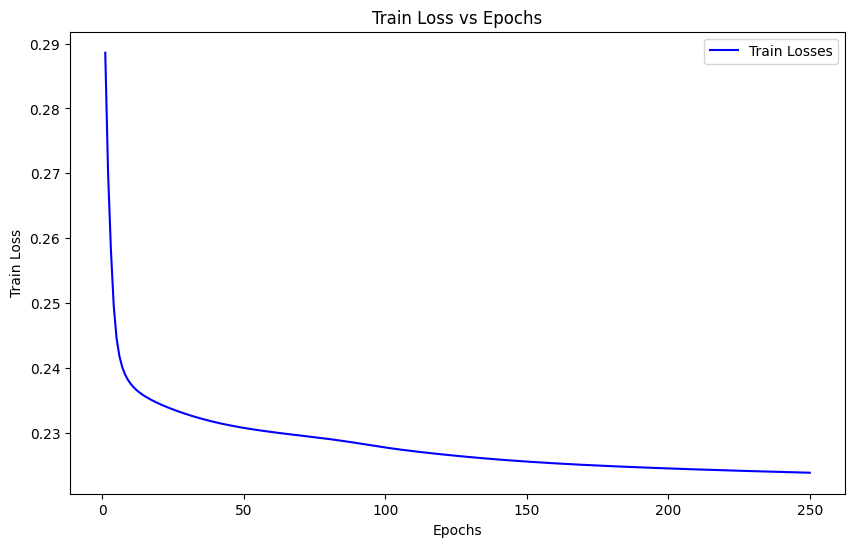

In [17]:
num_iters = 250
np.random.seed(42)
mlp = MLPClassifier(X_train_final,y_train ,0.01,'sigmoid',2, [6,6], num_iters, 'sgd', 6)
mlp.fit()
train_loss = mlp.train_losses

iter = list(range(1, num_iters+1))

plt.figure(figsize=(10, 6)) 
plt.plot(iter, train_loss, label='Train Losses', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Train Loss vs Epochs')
plt.legend()
plt.show()

In [18]:
print("Classification Report(On Validation Data): ")
print()
print(mlp.calculate_report(X_val_final, y_val))

Classification Report(On Validation Data): 

              precision    recall  f1-score   support

           3       1.00      0.00      0.00         2
           4       1.00      0.00      0.00         6
           5       0.57      0.75      0.64        63
           6       0.50      0.62      0.56        80
           7       1.00      0.00      0.00        27
           8       1.00      0.00      0.00         5

    accuracy                           0.53       183
   macro avg       0.84      0.23      0.20       183
weighted avg       0.63      0.53      0.46       183



In [19]:
learning_rates = [0.01, 0.05, 0.1]  
epochs_values = [200, 500, 1000]
hidden_layers_values = [[6, 6], [8, 8], [10, 10]] 
activation_functions = ['relu', 'tanh', 'sigmoid']
optimizers = ['sgd', 'minibatch', 'batch']

for optimizer in optimizers:
    for epochs_value in epochs_values:
        for hidden_layers in hidden_layers_values:
            for activation_function in activation_functions:
                for learning_rate in learning_rates:
                    run = wandb.init(
                        project="SMAI_As3_Q2", entity="mitanshkayathwal"
                    )
                    wandb.config.update({"Activation Function": activation_function, "Optimizer": optimizer })
                    mlp = MLPClassifier(X_train_final,y_train,learning_rate,activation_function,len(hidden_layers), hidden_layers, epochs_value, optimizer)
                    mlp.fit()
                    train_accuracy, train_precision, train_recall, train_f1sc = mlp.calculate_metrics(X_train_final, y_train)
                    val_accuracy, val_precision, val_recall, val_f1sc = mlp.calculate_metrics(X_val_final, y_val)
                    train_loss = mlp.get_loss(X_train_final, y_train)
                    val_loss = mlp.get_loss(X_val_final, y_val)
                    
                    wandb.log({
                        'Epochs': epochs_value,
                        'Hidden Layer': hidden_layers,
                        'Learning Rate': learning_rate,
                        'Validation Accuracy': val_accuracy,
                        'Validation Loss': val_loss,
                        'Train Loss': train_loss,
                        'Training Accuracy': train_accuracy,
                    })

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.62244
Validation Accuracy,0.47541


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.67442
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.61149
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.62107
Validation Accuracy,0.48087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.58687
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.60876
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.31327
Validation Accuracy,0.34973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.38714
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.3844
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.68263
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.62791
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.57866
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.61833
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.58003
Validation Accuracy,0.48634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.38988
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.42134
Validation Accuracy,0.33333


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.57592
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.66895
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.57182
Validation Accuracy,0.42623


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.64022
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.64295
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.61696
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.57045
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.57456
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.47606
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.63064
Validation Accuracy,0.48087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.59508
Validation Accuracy,0.48634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.00547
Validation Accuracy,0.01093


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.54993
Validation Accuracy,0.47541


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.61286
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.61012
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.35841
Validation Accuracy,0.34973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.51436
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.56772
Validation Accuracy,0.50273


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.68126
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.61286
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.52394
Validation Accuracy,0.46995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.60328
Validation Accuracy,0.54645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.61149
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.57729
Validation Accuracy,0.50273


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.55951
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.48837
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.57182
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.74419
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.00547
Validation Accuracy,0.01093


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.00547
Validation Accuracy,0.01093


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.66074
Validation Accuracy,0.55738


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.64432
Validation Accuracy,0.46995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.63611
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.5171
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.57456
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.58276
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.67305
Validation Accuracy,0.50273


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.65663
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.62517
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.63201
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.61149
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.56088
Validation Accuracy,0.48634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.39124
Validation Accuracy,0.45902


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.44049
Validation Accuracy,0.48087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.59781
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.73051
Validation Accuracy,0.57377


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.66074
Validation Accuracy,0.56284


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.41724
Validation Accuracy,0.30601


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.69083
Validation Accuracy,0.56831


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.64979
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.5896
Validation Accuracy,0.47541


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.43776
Validation Accuracy,0.32787


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.4446
Validation Accuracy,0.39891


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.60602
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.61423
Validation Accuracy,0.4153


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.63611
Validation Accuracy,0.54645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.19562
Validation Accuracy,0.18579


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.6156
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.69767
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.61696
Validation Accuracy,0.48634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.56772
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.56772
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.59918
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.11902
Validation Accuracy,0.12022


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.39672
Validation Accuracy,0.42077


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.35431
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.59508
Validation Accuracy,0.50273


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.63338
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.60602
Validation Accuracy,0.56831


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.49521
Validation Accuracy,0.36066


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.5554
Validation Accuracy,0.47541


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.38714
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.66758
Validation Accuracy,0.55191


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.66074
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.62107
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.6156
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.61286
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.57592
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.5554
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.4788
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.39261
Validation Accuracy,0.45355


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.57456
Validation Accuracy,0.40984


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.71819
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.68263
Validation Accuracy,0.56284


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.59918
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.63338
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.62654
Validation Accuracy,0.4918


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.49658
Validation Accuracy,0.37705


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.39945
Validation Accuracy,0.35519


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.55814
Validation Accuracy,0.4918


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.66074
Validation Accuracy,0.56284


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.64706
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.66621
Validation Accuracy,0.59016


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.59781
Validation Accuracy,0.4918


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.63338
Validation Accuracy,0.50273


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.62244
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.52394
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.58003
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.59097
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.69083
Validation Accuracy,0.61202


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.68673
Validation Accuracy,0.50273


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.70451
Validation Accuracy,0.56831


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.60192
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.69083
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.67442
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.43365
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.46375
Validation Accuracy,0.46995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.38714
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.73871
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.53215
Validation Accuracy,0.30601


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.70862
Validation Accuracy,0.57377


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.60876
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.66074
Validation Accuracy,0.46995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.60739
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.53762
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.49521
Validation Accuracy,0.42077


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.25581
Validation Accuracy,0.28962


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.68673
Validation Accuracy,0.57923


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.65937
Validation Accuracy,0.56284


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.64569
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.59508
Validation Accuracy,0.55738


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.64432
Validation Accuracy,0.49727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.61696
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.38714
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.54036
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.38714
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.70862
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.72093
Validation Accuracy,0.57377


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.6539
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.6238
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.64569
Validation Accuracy,0.55191


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.59508
Validation Accuracy,0.46995


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.55814
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.58687
Validation Accuracy,0.53552


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.6156
Validation Accuracy,0.54645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.61833
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.7264
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.71272
Validation Accuracy,0.5082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.60055
Validation Accuracy,0.48634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.71135
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.62107
Validation Accuracy,0.48087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.44323
Validation Accuracy,0.34973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.43639
Validation Accuracy,0.40437


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.54036
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.45417
Validation Accuracy,0.40437


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.57592
Validation Accuracy,0.48087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.487
Validation Accuracy,0.38251


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.28044
Validation Accuracy,0.21858


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.33516
Validation Accuracy,0.28415


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.45828
Validation Accuracy,0.37158


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.36662
Validation Accuracy,0.40984


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.43365
Validation Accuracy,0.45902


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.29138
Validation Accuracy,0.30601


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.28865
Validation Accuracy,0.2459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.45554
Validation Accuracy,0.36612


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.25992
Validation Accuracy,0.24044


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.26129
Validation Accuracy,0.21311


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.4446
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.17373
Validation Accuracy,0.15847


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.32285
Validation Accuracy,0.3388


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.4446
Validation Accuracy,0.38798


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.07524
Validation Accuracy,0.08743


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.50068
Validation Accuracy,0.38798


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.57729
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.15869
Validation Accuracy,0.13115


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.44733
Validation Accuracy,0.39344


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.44596
Validation Accuracy,0.36612


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.01
Training Accuracy,0.38714
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.05
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,200
Learning Rate,0.1
Training Accuracy,0.38714
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.16279
Validation Accuracy,0.19672


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.53762
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.44186
Validation Accuracy,0.34973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.31464
Validation Accuracy,0.22951


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.56224
Validation Accuracy,0.43716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.5814
Validation Accuracy,0.51366


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.41587
Validation Accuracy,0.38798


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.47196
Validation Accuracy,0.40437


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.40356
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.5212
Validation Accuracy,0.47541


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.54583
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.02326
Validation Accuracy,0.01639


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.35431
Validation Accuracy,0.37705


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.51573
Validation Accuracy,0.44809


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.53762
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.18194
Validation Accuracy,0.13115


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.46101
Validation Accuracy,0.37158


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.50889
Validation Accuracy,0.48634


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.26676
Validation Accuracy,0.19126


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.61833
Validation Accuracy,0.55191


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.63475
Validation Accuracy,0.54645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.22572
Validation Accuracy,0.2459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.50889
Validation Accuracy,0.46448


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.62517
Validation Accuracy,0.54645


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.01
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.05
Training Accuracy,0.41587
Validation Accuracy,0.38251


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,500
Learning Rate,0.1
Training Accuracy,0.49658
Validation Accuracy,0.45902


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.5472
Validation Accuracy,0.39891


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.44186
Validation Accuracy,0.35519


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.61833
Validation Accuracy,0.53005


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.34337
Validation Accuracy,0.29508


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.4788
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.55814
Validation Accuracy,0.52459


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.36389
Validation Accuracy,0.40437


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.50342
Validation Accuracy,0.45355


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.49248
Validation Accuracy,0.37705


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.66758
Validation Accuracy,0.55738


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.36115
Validation Accuracy,0.3224


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.5472
Validation Accuracy,0.44262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.43228
Validation Accuracy,0.51913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.43502
Validation Accuracy,0.34973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.4528
Validation Accuracy,0.37705


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.45007
Validation Accuracy,0.35519


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.38851
Validation Accuracy,0.28962


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.65116
Validation Accuracy,0.54098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.31737
Validation Accuracy,0.26776


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.31327
Validation Accuracy,0.33333


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.49384
Validation Accuracy,0.42623


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.1
Training Accuracy,0.56088
Validation Accuracy,0.46448


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.01
Training Accuracy,0.44323
Validation Accuracy,0.34426


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Training Accuracy,▁
Validation Accuracy,▁
Epochs,1000
Learning Rate,0.05
Training Accuracy,0.34747
Validation Accuracy,0.27869


# Best Hyperparameters found using WandB:

Epochs: 500

Learning Rate: 0.01

Hidden Layers: [8, 8]

Activation: relu

Optimizer: Minibatch

Training Accuracy: 69.08%

Validation Accuracy: 61.2%

In [24]:
mlp = MLPClassifier(X_test_final,y_test ,0.01,'relu',2, [8,8], 500, 'minibatch', 6)
mlp.fit()

print("Classification Report on Test Dataset using best Hyperparameters is:")
print()
print(mlp.calculate_report(X_test_final, y_test))

Classification Report on Test Dataset using best Hyperparameters is:

              precision    recall  f1-score   support

           4       1.00      0.00      0.00         6
           5       0.88      0.88      0.88        96
           6       0.76      0.87      0.81        99
           7       0.70      0.54      0.61        26
           8       1.00      0.00      0.00         2

    accuracy                           0.80       229
   macro avg       0.87      0.46      0.46       229
weighted avg       0.81      0.80      0.79       229



In [38]:
df = pd.read_csv("advertisement.csv")
df.head()

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home


In [39]:
inpX = df.iloc[:, :-1]
inpY = df.iloc[:, -1].str.split(' ')

In [40]:
numerical_features = [cname for cname in inpX.columns if inpX[cname].dtype in ['int64', 'float64']]
categorical_features = [cname for cname in inpX.columns if inpX[cname].dtype=='object']
binary_features = [cname for cname in inpX.columns if inpX[cname].dtype=='bool']

inpX.drop('city', axis = 1,inplace = True)

categorical_features = [cname for cname in inpX.columns if inpX[cname].dtype=='object']

inpY = [set(label_list) for label_list in inpY]

mlb = MultiLabelBinarizer()

finalY = mlb.fit_transform(inpY)

In [41]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi  =  train_test_split(inpX, finalY, test_size=0.2, random_state=42)
X_train_multi, X_val_multi, y_train_multi, y_val_multi  =  train_test_split(X_train_multi, y_train_multi, test_size=0.2, random_state=42)

In [42]:
categorical_features += binary_features

scaler = StandardScaler()

for feature in categorical_features:
    encoder = LabelEncoder()
    X_train_multi[feature] = encoder.fit_transform(X_train_multi[feature])
    X_val_multi[feature] = encoder.fit_transform(X_val_multi[feature])
    X_test_multi[feature] = encoder.transform(X_test_multi[feature])


X_train_multi[numerical_features] = scaler.fit_transform(X_train_multi[numerical_features])
X_val_multi[numerical_features] = scaler.fit_transform(X_val_multi[numerical_features])
X_test_multi[numerical_features] = scaler.transform(X_test_multi[numerical_features])

X_train_multi = X_train_multi.values
X_val_multi = X_val_multi.values
X_test_multi = X_test_multi.values

In [55]:
class MLPClassifierMultiLabel:
    def __init__(self, X, y, learning_rate, activation_fn, num_layers, hidden_layer_sizes, epochs, optimizer='sgd', output_size = 6):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.activation = activation_fn
        self.num_layers = num_layers
        self.hidden_layer_sizes = hidden_layer_sizes
        self.epochs = epochs
        self.output_size = output_size
        if(optimizer == 'sgd'):
            self.optimizer = self.stochastic_gradient_descent
        elif(optimizer == 'batch'):
            self.optimizer = self.batch_gradient_descent
        else:
            self.optimizer = self.minibatch_gradient_descent
    
    def one_hot_encode(self, y):
        max_label_num = 6
        one_hot_matrix = np.zeros((len(y), max_label_num))
        one_hot_matrix[np.arange(len(y)), np.array(y) - 3] = 1
        
        return one_hot_matrix
    
    def binary_cross_entropy_loss(self, y_true, y_pred):
        epsilon = 1e-15  
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  
        loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return np.mean(loss) 
    
    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def tanh(self, x):
        return np.tanh(x)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def initialize_params(self):
        layers = [self.X.shape[1]] + self.hidden_layer_sizes + [self.output_size]

        self.weights = [np.random.randn(layers[i], layers[i+1]) for i in range(0,len(layers)-1)]
        self.biases = [np.zeros((1, layers[i])) for i in range(1,len(layers))]
        
    def derivative_activation(self, x):
        if self.activation == 'relu':
            return (x > 0).astype(float)
        elif self.activation == 'sigmoid':
            return x * (1 - x)
        elif self.activation == 'tanh':
            return 1 - x**2
    
    def forward_propagation(self, X):
        self.activations = []
        activation_output = -1
        layer_input = X
        self.activations.append(layer_input)
        for i in range(len(self.hidden_layer_sizes)+1):
            layer_output = np.dot(layer_input, self.weights[i]) + self.biases[i]
            if (self.activation == 'sigmoid' or i==len(self.hidden_layer_sizes)):
                activation_output = self.sigmoid(layer_output)
            elif self.activation == 'relu':
                activation_output = self.relu(layer_output)
            elif self.activation == 'tanh':
                activation_output = self.tanh(layer_output)
            self.activations.append(activation_output)
            layer_input = activation_output

        self.output = self.activations[-1]
        return self.output

    def accuracy(self, y_pred, y):
        return accuracy_score(y_pred,y)

    def backward_propagation(self, y):
        gradient_weights = [np.zeros(w.shape) for w in self.weights]
        gradient_biases = [np.zeros(b.shape) for b in self.biases]
        error = (self.output - y)
        for i in range(1,len(self.weights)+1):
            gradient_weights[-i] = (self.activations[-i-1].T.dot(error))/len(y)
            gradient_biases[-i] = np.sum(error, axis=0, keepdims=True)/len(y)
            if(i!=len(self.weights)):
                error = self.derivative_activation(self.activations[-i-1])*(error.dot(self.weights[-i].T))
        return gradient_weights , gradient_biases
    

    def batch_gradient_descent(self):
        for epoch in range(self.epochs):
            self.forward_propagation(self.X)
            gradient_weights, gradient_biases = self.backward_propagation(self.y)
            train_loss = self.binary_cross_entropy_loss(self.y,self.output)
            self.train_losses.append(train_loss)
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * gradient_weights[i]
                self.biases[i] -= self.learning_rate * gradient_biases[i]

    def minibatch_gradient_descent(self):
        batch_size = 8
        for epoch in range(self.epochs):
            X_batches = np.array_split(self.X,len(self.X)/batch_size)
            Y_batches = np.array_split(self.y,len(self.y)/batch_size)
            train_loss = 0
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.forward_propagation(batch_x)
                grad_w, grad_b = self.backward_propagation(batch_y)
                train_loss = train_loss + self.binary_cross_entropy_loss(batch_y, self.output)
                for i in range(len(self.weights)):
                    self.weights[i] -= self.learning_rate * grad_w[i]
                    self.biases[i] -= self.learning_rate * grad_b[i]     
            self.train_losses.append(train_loss/len(X_batches))
    
    def stochastic_gradient_descent(self):
        batch_size = 1
        for epoch in range(self.epochs):
            train_loss = 0
            X_batches = np.array_split(self.X,len(self.X)/batch_size)
            Y_batches = np.array_split(self.y,len(self.y)/batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.forward_propagation(batch_x)
                grad_w, grad_b = self.backward_propagation(batch_y)
                train_loss = train_loss + self.binary_cross_entropy_loss(batch_y, self.output)
                for i in range(len(self.weights)):
                    self.weights[i] -= self.learning_rate * grad_w[i]
                    self.biases[i] -= self.learning_rate * grad_b[i]
            self.train_losses.append(train_loss/len(X_batches))
            
    def fit_multilabel(self):
        self.initialize_params()
        self.train_losses = []
        self.optimizer()

    def multilabel_calculate_metrics(self, X, y):
        predictions = self.forward_propagation(X)
        predicted_labels = (predictions > 0.5).astype(int)

        return self.binary_cross_entropy_loss(y, predicted_labels), hamming_loss(predicted_labels, y), accuracy_score(predicted_labels, y)
    
    def calculate_report(self, X, y):
        predictions = self.forward_propagation(X)

        predicted_labels =  (predictions > 0.5).astype(int)
        report = classification_report(y, predicted_labels,zero_division=1)
        return report

In [49]:
np.random.seed(42)
mlp_multilabel = MLPClassifierMultiLabel(X_train_multi, y_train_multi, 0.01,'sigmoid', 1, [10], 2000, 'minibatch', len(y_train_multi[0]))

mlp_multilabel.fit_multilabel()

In [50]:
mlp_multilabel.multilabel_calculate_metrics(X_test_multi, y_test_multi)

(10.922919519039317, 0.31625, 0.035)

In [54]:
learning_rates = [0.01, 0.1]  
epochs_values = [500, 1000]
hidden_layers_values = [[8, 8], [10, 10]] 
activation_functions = ['relu', 'tanh', 'sigmoid']
optimizers = ['sgd', 'minibatch', 'batch']


for optimizer in optimizers:
    for epochs_value in epochs_values:
        for hidden_layers in hidden_layers_values:
            for activation_function in activation_functions:
                for learning_rate in learning_rates:
                    run = wandb.init(
                        project="SMAI_As3_Q2MultiLabel", entity="mitanshkayathwal"
                    )
                    wandb.config.update({"Activation Function": activation_function, "Optimizer": optimizer })
                    mlp = MLPClassifierMultiLabel(X_train_multi,y_train_multi,learning_rate,activation_function,len(hidden_layers), hidden_layers, epochs_value, optimizer,len(y_train_multi[0]) )
                    mlp.fit_multilabel()
                    train_loss, train_hamming, train_accuracy = mlp.multilabel_calculate_metrics(X_train_multi, y_train_multi)
                    val_loss, val_hamming, val_accuracy = mlp.multilabel_calculate_metrics(X_val_multi, y_val_multi)
  
                    wandb.log({
                        'Epochs': epochs_value,
                        'Hidden Layer': hidden_layers,
                        'Learning Rate': learning_rate,
                        'Validation Accuracy': val_accuracy,
                        'Train Hamming Loss': train_hamming,
                        'Validation Loss': val_loss,
                        'Train Loss': train_loss,
                        'Training Accuracy': train_accuracy,
                        'Validation Hamming Loss': val_hamming
                    })

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.33789


/var/folders/z6/m0l9ypjs6z39w60tv7__dxhc0000gn/T/ipykernel_2639/2162390152.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.34941


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.32559


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.33984


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.32266


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.32461


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.33418


/var/folders/z6/m0l9ypjs6z39w60tv7__dxhc0000gn/T/ipykernel_2639/2162390152.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.3498


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.32266


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.33945


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.32051


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.32383


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.34551


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.34941


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.32656


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.34063


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.30996


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.32383


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.32891


/var/folders/z6/m0l9ypjs6z39w60tv7__dxhc0000gn/T/ipykernel_2639/2162390152.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.3498


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.32363


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.3582


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.31562


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.32695


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.34199


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.3498


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.32676


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.32441


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.33633


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.32305


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.3334


/var/folders/z6/m0l9ypjs6z39w60tv7__dxhc0000gn/T/ipykernel_2639/2162390152.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.33457


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.33535


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.32773


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.33379


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.31484


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.3334


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.3498


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.32754


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.32129


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.32598


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.31328


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.32773


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.3498


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.3127


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.32246


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.3252


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.31016


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.35098


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.34961


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.35234


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.33828


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.34609


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.34375


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.34473


/var/folders/z6/m0l9ypjs6z39w60tv7__dxhc0000gn/T/ipykernel_2639/2162390152.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.3498


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.35547


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.33457


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.01
Train Hamming Loss,0.34922


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,500
Learning Rate,0.1
Train Hamming Loss,0.34063


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.34902


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.34727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.35078


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.33496


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.34727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.34082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.34414


/var/folders/z6/m0l9ypjs6z39w60tv7__dxhc0000gn/T/ipykernel_2639/2162390152.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.35


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.34844


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.1
Train Hamming Loss,0.32949


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epochs,▁
Learning Rate,▁
Train Hamming Loss,▁
Train Loss,▁
Training Accuracy,▁
Validation Accuracy,▁
Validation Hamming Loss,▁
Validation Loss,▁
Epochs,1000
Learning Rate,0.01
Train Hamming Loss,0.35684


wandb: Network error (ReadTimeout), entering retry loop.


# Best Hyperparameters found using WandB:

Epochs: 500

Learning Rate: 0.01

Hidden Layers: [10, 10]

Activation: sigmoid

Optimizer: Minibatch

Training Accuracy: 1.7%

Validation Accuracy: 1.8%

Training Hamming Loss: 33%

Validation Hamming Loss: 33.5%

In [63]:
mlp = MLPClassifierMultiLabel(X_train_multi,y_train_multi ,0.01,'sigmoid',2, [8,8], 500, 'minibatch', len(y_train_multi[0]))
mlp.fit_multilabel()
test_loss, test_hamming, test_accuracy = mlp.multilabel_calculate_metrics(X_train_multi, y_train_multi)

print("Classification Report on Test Dataset using best Hyperparameters is:")
print()
print(mlp.calculate_report(X_test_multi, y_test_multi))

print("Test Accuracy: " + str(test_accuracy*100) + "%")

Classification Report on Test Dataset using best Hyperparameters is:

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        68
           1       1.00      0.00      0.00        66
           2       1.00      0.00      0.00        63
           3       1.00      0.00      0.00        63
           4       0.55      0.19      0.28        59
           5       0.50      0.15      0.23        66
           6       1.00      0.00      0.00        71
           7       0.96      0.38      0.55        71

   micro avg       0.71      0.09      0.16       527
   macro avg       0.88      0.09      0.13       527
weighted avg       0.88      0.09      0.13       527
 samples avg       0.95      0.12      0.16       527

Test Accuracy: 2.5%
